<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/hyperparameters/hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters for a Binary classification problem

The goal of this workshop is to get familiar with:
- the concept of hyperparameters
- what the usual hyperparameters are for a neural network and what are their effects
- how to tune them and validate a choice of hyperparameters


## Hyperparameters

In the prerequisites you trained a very small model to learn the sinus function. In the process, you had to make many decisions, such as to use a degree 3 polynomial, to use a specific learning rate, etc.

The learning rate is an example of a **hyperparameter**, which will be described below. As a reminder, a regular parameter is an adjustable value with the special and extremely convenient property that we can differentiate the loss with respect to the parameter, allowing us to efficiently learn good values for the parameter using gradient descent. In other words, the process of training is a function that takes a dataset, a model architecture, and a random seed and outputs model parameters.

The learning rate, in contrast, cannot be determined by this scheme. As a hyperparameter, we need to introduce an outer loop that wraps the training loop to search for good learning rate values. This outer loop is called a hyperparameter search, and each iteration consists of testing different combinations of hyperparameters using a dataset of pairs of $(\text{hyperparameters}, \text{validation performance})$. Obtaining results for each iteration (a single pair) requires running the inner training loop.

Due to a fixed budget of ML researcher time and available compute, we are interested in a trade-off between the ML researcher time, the cost of running the search, and the cost of training the final model. Due to the vast search space and cost of obtaining data, we don't hope to find any sort of optimum but merely to improve upon our initial guesses enough to justify the cost.

In addition, a hyperparameter isn't necessarily a single continuous value like the learning rate. Discrete unordered choices such as padding type as well as discrete ordered choices such as the number of layers in the network or the width of each convolution are all common. You will also need to choose between functions for optimizers, nonlinearities, or learning rate scheduling, of which there are an infinite number of possibilities, requiring us to select a small subset to test.

More broadly, every design decision can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, the types of operations, etc. Papers such as [AmeobaNet](https://arxiv.org/pdf/1801.01548.pdf) demonstrated that it's possible to find architectures superior to human-designed ones.

In the second part of this workshop, you will be able to test various strategies for searching over hyperparameters.

## The dataset

We study first a binary classification problem, performed by a neural network. Each input has two real features, that is, they are points in 2D and the output can be only 0 or 1.

The training set contains 4000 examples, and the validation set, 1000.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [3]:
# We define a function to generate our synthetic the dataset, in the form of two interlaced spirals
# You don't need to understand this code, just run it


def spiral(phi):
    x = (phi + 1) * torch.cos(phi)
    y = phi * torch.sin(phi)
    return torch.cat((x, y), dim=1)


def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data // 2 :, :] *= -1
    labels[num_data // 2 :] = 1
    return data, labels

In [4]:
# Generate the training set with 4000 examples
x_train, y_train = generate_data(4000)

print("X_train", x_train.shape)
print("y_train", y_train.shape)

X_train torch.Size([4000, 2])
y_train torch.Size([4000])


In [5]:
def plot_data(x, y):
    """Plot labeled data points X and y. Label 1 is a red +, label 0 is a blue +."""
    plt.figure(figsize=(5, 5))
    plt.plot(x[y == 1, 0], x[y == 1, 1], "r+")
    plt.plot(x[y == 0, 0], x[y == 0, 1], "b+")

We can now invoke the `plot_data` function on the dataset previously generated to see what it looks like:

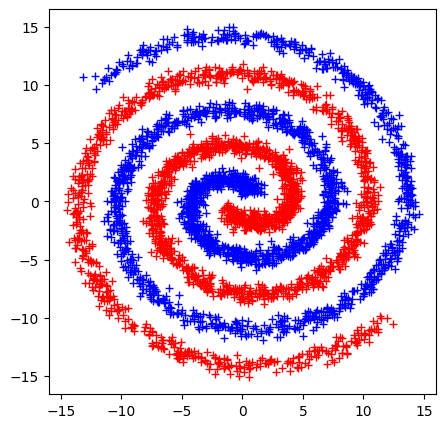

In [6]:
plot_data(x_train, y_train)

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

A `Dataset` in PyTorch holds together the inputs and the corresponding labels (if any), and provides a way to access them.
It also interfaces neatly with the `DataLoader` class, which is used to load the data in batches, shuffle it, etc.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

training_set = TensorDataset(x_train, y_train)

##  A neural network to classify the data

Here is a skeleton of a neural network with, by default, a single hidden layer. This is the model you'll try to improve during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just two layers. A useful tutorial for constructing models can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [9]:
# Don't just run, but also read this code, it's code you would find again many times in the future

from typing_extensions import Literal


class Model(nn.Module):
    """
    A fully connected neural network with any number of layers.
    """

    NAME_TO_NONLINEARITY = {
        "relu": nn.ReLU,
        "sigmoid": nn.Sigmoid,
        "tanh": nn.Tanh,
    }

    def __init__(
        self, layers=[2, 10, 1], non_linearity: Literal["relu", "sigmoid", "tanh"] = "relu"
    ):
        super(Model, self).__init__()

        modules = []
        for input_dim, output_dim in zip(layers[:-1], layers[1:]):
            modules.append(nn.Linear(input_dim, output_dim))
            # After each linear layer, we apply a non-linearity
            modules.append(self.NAME_TO_NONLINEARITY[non_linearity]())

        # Remove the last non-linearity, since the last layer is the output layer
        self.layers = nn.Sequential(*modules[:-1])

    def forward(self, inputs):
        ouput = self.layers(inputs)

        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function appropriate to map the output from [-inf, inf] to [0, 1]
        prediction = torch.sigmoid(ouput)
        return prediction

In [10]:
# Create the model:
model = Model()

# Choose the hyperparameters for training:
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate (lr) of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training the model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) if needed.

In [11]:
# tqdm is a library used to display progress bars. It's extremely useful when training.
from tqdm.notebook import tqdm


def train(
    num_epochs: int, batch_size: int, criterion, optimizer, model, dataset, verbose: bool = False
):
    """Train a model."""
    # Store the training errors
    train_losses = []
    # Create a DataLoader to iterate over the dataset in batches
    train_loader = DataLoader(dataset, batch_size, shuffle=True)

    for epoch in tqdm(range(num_epochs)):
        epoch_average_loss = 0
        # Each epoch, we iterate over the dataset once
        for x_batch, y_true in train_loader:
            # Compute the predictions.
            # Output shape is (batch_size, 1), so we squeeze the last dimension
            y_predicted = model(x_batch).squeeze(1)

            # The loss is how far the predictions are from the true labels
            loss = criterion(y_predicted, y_true.float())

            # Do gradient descent to minimize the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record the average loss for this batch
            epoch_average_loss += loss.item() * batch_size / len(dataset)

        train_losses.append(epoch_average_loss)

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_average_loss:.4f}")

    return train_losses

In [12]:
train_losses = train(num_epochs, batch_size, criterion, optimizer, model, training_set, 1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2526
Epoch [2/10], Loss: 0.2461
Epoch [3/10], Loss: 0.2455
Epoch [4/10], Loss: 0.2452
Epoch [5/10], Loss: 0.2451
Epoch [6/10], Loss: 0.2445
Epoch [7/10], Loss: 0.2447
Epoch [8/10], Loss: 0.2443
Epoch [9/10], Loss: 0.2443
Epoch [10/10], Loss: 0.2443


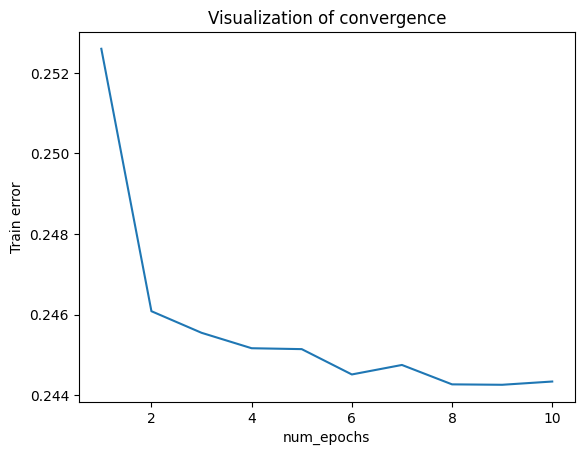

In [13]:
# Plot the training error wrt. the number of epochs
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

## Evaluating the model on the validation set

We first evaluate the accuracy on a validation set, to see how the model performs on unseen data.

In [14]:
# Generate 1000 validation datapoints
x_val, y_val = generate_data(1000)


def get_accuracy(model, x=x_val, y=y_val):
    """Compute the accuracy of the model on a dataset."""
    # Compute the predictions, without keeping track of the gradients
    with torch.no_grad():
        y_predicted = model(x).squeeze(1)

    # The predictions are in [0, 1] and the labels are either 0 or 1
    # So we round the predictions to get the predicted labels
    y_predicted = torch.round(y_predicted)

    # Compute the accuracy by counting the number of correct predictions
    accuracy = (y_predicted == y).sum().item() / len(y)

    print(f"Accuracy on {len(y)} examples: {accuracy:.2%}")
    return accuracy

In [15]:
get_accuracy(model)

Accuracy on 1000 examples: 57.10%


0.571

Then we visualize what the model has learned by plotting all the predictions.

In [16]:
def compare_predictions(model, x=x_val, y_real=y_val):
    """Compare the prediction with real labels."""

    with torch.no_grad():
        y_predicted = model(x).squeeze(1)

    plt.figure(figsize=(10, 5))

    reds = y_real > 0.5
    plt.subplot(121)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("real data")

    reds = y_predicted > 0.5
    plt.subplot(122)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("predicted data")

    plt.show()

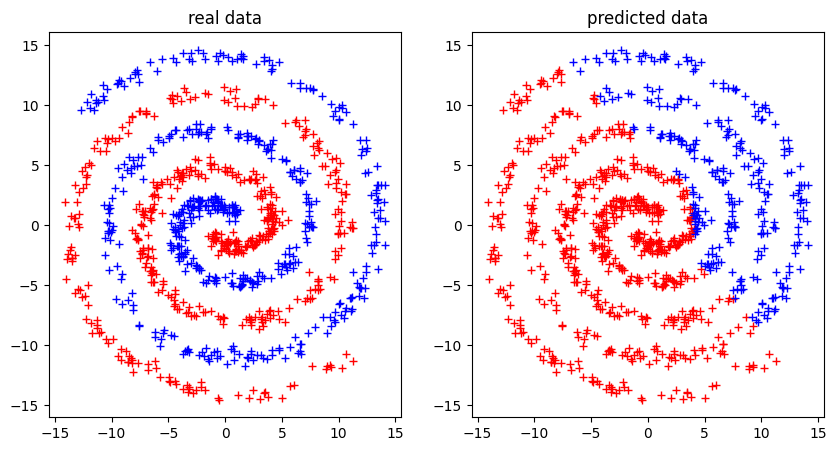

In [17]:
compare_predictions(model)

## Meta-optimisation

We defined a lot a hyper-parameters (learning rate, layer sizes...) in the previous section. We will now try to find the best combination of hyper-parameters.

> WARNING: For this exercise to be maximally useful, before you start answering the questions, try to make predictions about the impact of each meta-parameter.
Afterwards, you can check that the predictions were correct.

Bonus: if you want, you can make your predictions on [FateBook](https://fatebook.io).


Questions:
- Meta optimization: The goal of this tutorial is to get a summary table of the impact of each meta-parameter by clicking once on the "Run All" button.
To do this, you need to think about the difference between the grid search strategy and the sensitivity analysis strategy? Which strategy is more suitable in case there are a lot of meta parameters? Try to implement this strategy in the following.
- Why do you need the test dataset in addition to the validation dataset?

### Exercise 1: Impact of the optimizer

Retrain the model by using different hyperparameters, you can change them in the previous sections definition, or put everything you need in the cell below for convenience.

Try to see the impact of the following factors:
* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process.
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [18]:
import itertools

In [19]:
def define_config(model, num_epochs, batch_size, criterion, optimiser):
    train_losses = train(num_epochs, batch_size, criterion, optimiser, model, training_set, 1)

    # Plot the training error wrt. the number of epochs
    '''
    plt.plot(range(1, num_epochs + 1), train_losses)
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")
    plt.show()
    '''

    get_accuracy(model)
    # compare_predictions(model)

In [35]:
BATCH_SIZES = [32, 64, 128, 256]
LEARNING_RATES = [0.001, 0.01, 0.1, 1, 10]
NUM_EPOCHS = [5, 10, 15, 20]

In [39]:
HYPER_PARAMS = [BATCH_SIZES, LEARNING_RATES, NUM_EPOCHS]

In [40]:
for batch_size, lr, num_epochs in itertools.product(*HYPER_PARAMS):
    model = Model()
    criterion = nn.MSELoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=lr)
    print(f'Testing config with:\nBatch size: {batch_size}\nLearning rate: {lr}\nNum epochs: {num_epochs}\nSGD Optimiser\nMSELoss')
    define_config(model, num_epochs, batch_size, criterion, optimiser)

Testing config with:
Batch size: 32
Learning rate: 0.001
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2728
Epoch [2/5], Loss: 0.2677
Epoch [3/5], Loss: 0.2642
Epoch [4/5], Loss: 0.2616
Epoch [5/5], Loss: 0.2597
Accuracy on 1000 examples: 50.60%
Testing config with:
Batch size: 32
Learning rate: 0.001
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2947
Epoch [2/10], Loss: 0.2809
Epoch [3/10], Loss: 0.2671
Epoch [4/10], Loss: 0.2572
Epoch [5/10], Loss: 0.2523
Epoch [6/10], Loss: 0.2501
Epoch [7/10], Loss: 0.2489
Epoch [8/10], Loss: 0.2481
Epoch [9/10], Loss: 0.2474
Epoch [10/10], Loss: 0.2470
Accuracy on 1000 examples: 52.50%
Testing config with:
Batch size: 32
Learning rate: 0.001
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3423
Epoch [2/15], Loss: 0.3349
Epoch [3/15], Loss: 0.3256
Epoch [4/15], Loss: 0.3135
Epoch [5/15], Loss: 0.2976
Epoch [6/15], Loss: 0.2797
Epoch [7/15], Loss: 0.2660
Epoch [8/15], Loss: 0.2588
Epoch [9/15], Loss: 0.2555
Epoch [10/15], Loss: 0.2536
Epoch [11/15], Loss: 0.2524
Epoch [12/15], Loss: 0.2516
Epoch [13/15], Loss: 0.2509
Epoch [14/15], Loss: 0.2505
Epoch [15/15], Loss: 0.2501
Accuracy on 1000 examples: 49.30%
Testing config with:
Batch size: 32
Learning rate: 0.001
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2748
Epoch [2/20], Loss: 0.2648
Epoch [3/20], Loss: 0.2567
Epoch [4/20], Loss: 0.2514
Epoch [5/20], Loss: 0.2485
Epoch [6/20], Loss: 0.2471
Epoch [7/20], Loss: 0.2465
Epoch [8/20], Loss: 0.2462
Epoch [9/20], Loss: 0.2460
Epoch [10/20], Loss: 0.2459
Epoch [11/20], Loss: 0.2458
Epoch [12/20], Loss: 0.2457
Epoch [13/20], Loss: 0.2457
Epoch [14/20], Loss: 0.2456
Epoch [15/20], Loss: 0.2455
Epoch [16/20], Loss: 0.2455
Epoch [17/20], Loss: 0.2454
Epoch [18/20], Loss: 0.2453
Epoch [19/20], Loss: 0.2453
Epoch [20/20], Loss: 0.2452
Accuracy on 1000 examples: 53.00%
Testing config with:
Batch size: 32
Learning rate: 0.01
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2957
Epoch [2/5], Loss: 0.2501
Epoch [3/5], Loss: 0.2466
Epoch [4/5], Loss: 0.2456
Epoch [5/5], Loss: 0.2453
Accuracy on 1000 examples: 53.00%
Testing config with:
Batch size: 32
Learning rate: 0.01
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2605
Epoch [2/10], Loss: 0.2528
Epoch [3/10], Loss: 0.2504
Epoch [4/10], Loss: 0.2488
Epoch [5/10], Loss: 0.2477
Epoch [6/10], Loss: 0.2467
Epoch [7/10], Loss: 0.2460
Epoch [8/10], Loss: 0.2456
Epoch [9/10], Loss: 0.2450
Epoch [10/10], Loss: 0.2447
Accuracy on 1000 examples: 53.70%
Testing config with:
Batch size: 32
Learning rate: 0.01
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2797
Epoch [2/15], Loss: 0.2507
Epoch [3/15], Loss: 0.2449
Epoch [4/15], Loss: 0.2433
Epoch [5/15], Loss: 0.2430
Epoch [6/15], Loss: 0.2425
Epoch [7/15], Loss: 0.2424
Epoch [8/15], Loss: 0.2422
Epoch [9/15], Loss: 0.2421
Epoch [10/15], Loss: 0.2421
Epoch [11/15], Loss: 0.2416
Epoch [12/15], Loss: 0.2418
Epoch [13/15], Loss: 0.2415
Epoch [14/15], Loss: 0.2415
Epoch [15/15], Loss: 0.2415
Accuracy on 1000 examples: 55.10%
Testing config with:
Batch size: 32
Learning rate: 0.01
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2556
Epoch [2/20], Loss: 0.2474
Epoch [3/20], Loss: 0.2469
Epoch [4/20], Loss: 0.2467
Epoch [5/20], Loss: 0.2467
Epoch [6/20], Loss: 0.2463
Epoch [7/20], Loss: 0.2464
Epoch [8/20], Loss: 0.2463
Epoch [9/20], Loss: 0.2461
Epoch [10/20], Loss: 0.2460
Epoch [11/20], Loss: 0.2457
Epoch [12/20], Loss: 0.2457
Epoch [13/20], Loss: 0.2455
Epoch [14/20], Loss: 0.2454
Epoch [15/20], Loss: 0.2451
Epoch [16/20], Loss: 0.2450
Epoch [17/20], Loss: 0.2449
Epoch [18/20], Loss: 0.2447
Epoch [19/20], Loss: 0.2446
Epoch [20/20], Loss: 0.2444
Accuracy on 1000 examples: 54.00%
Testing config with:
Batch size: 32
Learning rate: 0.1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2499
Epoch [2/5], Loss: 0.2458
Epoch [3/5], Loss: 0.2437
Epoch [4/5], Loss: 0.2435
Epoch [5/5], Loss: 0.2429
Accuracy on 1000 examples: 58.90%
Testing config with:
Batch size: 32
Learning rate: 0.1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2510
Epoch [2/10], Loss: 0.2469
Epoch [3/10], Loss: 0.2468
Epoch [4/10], Loss: 0.2467
Epoch [5/10], Loss: 0.2468
Epoch [6/10], Loss: 0.2442
Epoch [7/10], Loss: 0.2448
Epoch [8/10], Loss: 0.2428
Epoch [9/10], Loss: 0.2437
Epoch [10/10], Loss: 0.2423
Accuracy on 1000 examples: 52.00%
Testing config with:
Batch size: 32
Learning rate: 0.1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2593
Epoch [2/15], Loss: 0.2475
Epoch [3/15], Loss: 0.2465
Epoch [4/15], Loss: 0.2454
Epoch [5/15], Loss: 0.2436
Epoch [6/15], Loss: 0.2434
Epoch [7/15], Loss: 0.2413
Epoch [8/15], Loss: 0.2415
Epoch [9/15], Loss: 0.2404
Epoch [10/15], Loss: 0.2387
Epoch [11/15], Loss: 0.2380
Epoch [12/15], Loss: 0.2375
Epoch [13/15], Loss: 0.2370
Epoch [14/15], Loss: 0.2355
Epoch [15/15], Loss: 0.2374
Accuracy on 1000 examples: 59.70%
Testing config with:
Batch size: 32
Learning rate: 0.1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2521
Epoch [2/20], Loss: 0.2483
Epoch [3/20], Loss: 0.2461
Epoch [4/20], Loss: 0.2453
Epoch [5/20], Loss: 0.2454
Epoch [6/20], Loss: 0.2444
Epoch [7/20], Loss: 0.2439
Epoch [8/20], Loss: 0.2432
Epoch [9/20], Loss: 0.2419
Epoch [10/20], Loss: 0.2424
Epoch [11/20], Loss: 0.2408
Epoch [12/20], Loss: 0.2403
Epoch [13/20], Loss: 0.2402
Epoch [14/20], Loss: 0.2397
Epoch [15/20], Loss: 0.2396
Epoch [16/20], Loss: 0.2396
Epoch [17/20], Loss: 0.2385
Epoch [18/20], Loss: 0.2383
Epoch [19/20], Loss: 0.2384
Epoch [20/20], Loss: 0.2371
Accuracy on 1000 examples: 60.70%
Testing config with:
Batch size: 32
Learning rate: 1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2572
Epoch [2/5], Loss: 0.2456
Epoch [3/5], Loss: 0.2444
Epoch [4/5], Loss: 0.2439
Epoch [5/5], Loss: 0.2429
Accuracy on 1000 examples: 53.20%
Testing config with:
Batch size: 32
Learning rate: 1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2590
Epoch [2/10], Loss: 0.2440
Epoch [3/10], Loss: 0.2432
Epoch [4/10], Loss: 0.2439
Epoch [5/10], Loss: 0.2435
Epoch [6/10], Loss: 0.2430
Epoch [7/10], Loss: 0.2427
Epoch [8/10], Loss: 0.2439
Epoch [9/10], Loss: 0.2439
Epoch [10/10], Loss: 0.2437
Accuracy on 1000 examples: 53.50%
Testing config with:
Batch size: 32
Learning rate: 1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2658
Epoch [2/15], Loss: 0.2451
Epoch [3/15], Loss: 0.2443
Epoch [4/15], Loss: 0.2446
Epoch [5/15], Loss: 0.2422
Epoch [6/15], Loss: 0.2437
Epoch [7/15], Loss: 0.2433
Epoch [8/15], Loss: 0.2433
Epoch [9/15], Loss: 0.2434
Epoch [10/15], Loss: 0.2422
Epoch [11/15], Loss: 0.2421
Epoch [12/15], Loss: 0.2425
Epoch [13/15], Loss: 0.2428
Epoch [14/15], Loss: 0.2429
Epoch [15/15], Loss: 0.2424
Accuracy on 1000 examples: 57.30%
Testing config with:
Batch size: 32
Learning rate: 1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2605
Epoch [2/20], Loss: 0.2442
Epoch [3/20], Loss: 0.2443
Epoch [4/20], Loss: 0.2425
Epoch [5/20], Loss: 0.2430
Epoch [6/20], Loss: 0.2422
Epoch [7/20], Loss: 0.2429
Epoch [8/20], Loss: 0.2426
Epoch [9/20], Loss: 0.2410
Epoch [10/20], Loss: 0.2414
Epoch [11/20], Loss: 0.2431
Epoch [12/20], Loss: 0.2422
Epoch [13/20], Loss: 0.2421
Epoch [14/20], Loss: 0.2432
Epoch [15/20], Loss: 0.2426
Epoch [16/20], Loss: 0.2421
Epoch [17/20], Loss: 0.2428
Epoch [18/20], Loss: 0.2419
Epoch [19/20], Loss: 0.2420
Epoch [20/20], Loss: 0.2429
Accuracy on 1000 examples: 57.20%
Testing config with:
Batch size: 32
Learning rate: 10
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.3754
Epoch [2/5], Loss: 0.3623
Epoch [3/5], Loss: 0.3575
Epoch [4/5], Loss: 0.3563
Epoch [5/5], Loss: 0.3492
Accuracy on 1000 examples: 56.40%
Testing config with:
Batch size: 32
Learning rate: 10
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.4411
Epoch [2/10], Loss: 0.3895
Epoch [3/10], Loss: 0.3786
Epoch [4/10], Loss: 0.3880
Epoch [5/10], Loss: 0.3802
Epoch [6/10], Loss: 0.3682
Epoch [7/10], Loss: 0.3891
Epoch [8/10], Loss: 0.4002
Epoch [9/10], Loss: 0.3934
Epoch [10/10], Loss: 0.3889
Accuracy on 1000 examples: 48.70%
Testing config with:
Batch size: 32
Learning rate: 10
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3897
Epoch [2/15], Loss: 0.3597
Epoch [3/15], Loss: 0.3593
Epoch [4/15], Loss: 0.3616
Epoch [5/15], Loss: 0.3661
Epoch [6/15], Loss: 0.3587
Epoch [7/15], Loss: 0.3639
Epoch [8/15], Loss: 0.3568
Epoch [9/15], Loss: 0.3535
Epoch [10/15], Loss: 0.3594
Epoch [11/15], Loss: 0.3605
Epoch [12/15], Loss: 0.3512
Epoch [13/15], Loss: 0.3501
Epoch [14/15], Loss: 0.3530
Epoch [15/15], Loss: 0.3533
Accuracy on 1000 examples: 57.00%
Testing config with:
Batch size: 32
Learning rate: 10
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3772
Epoch [2/20], Loss: 0.3704
Epoch [3/20], Loss: 0.4014
Epoch [4/20], Loss: 0.3996
Epoch [5/20], Loss: 0.3900
Epoch [6/20], Loss: 0.3759
Epoch [7/20], Loss: 0.3788
Epoch [8/20], Loss: 0.3754
Epoch [9/20], Loss: 0.3772
Epoch [10/20], Loss: 0.3663
Epoch [11/20], Loss: 0.3613
Epoch [12/20], Loss: 0.3589
Epoch [13/20], Loss: 0.3580
Epoch [14/20], Loss: 0.3680
Epoch [15/20], Loss: 0.3580
Epoch [16/20], Loss: 0.3559
Epoch [17/20], Loss: 0.3571
Epoch [18/20], Loss: 0.3556
Epoch [19/20], Loss: 0.3669
Epoch [20/20], Loss: 0.3694
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 64
Learning rate: 0.001
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.3613
Epoch [2/5], Loss: 0.3575
Epoch [3/5], Loss: 0.3539
Epoch [4/5], Loss: 0.3501
Epoch [5/5], Loss: 0.3470
Accuracy on 1000 examples: 41.10%
Testing config with:
Batch size: 64
Learning rate: 0.001
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3197
Epoch [2/10], Loss: 0.3143
Epoch [3/10], Loss: 0.3113
Epoch [4/10], Loss: 0.3066
Epoch [5/10], Loss: 0.3020
Epoch [6/10], Loss: 0.2978
Epoch [7/10], Loss: 0.2926
Epoch [8/10], Loss: 0.2888
Epoch [9/10], Loss: 0.2838
Epoch [10/10], Loss: 0.2797
Accuracy on 1000 examples: 56.40%
Testing config with:
Batch size: 64
Learning rate: 0.001
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2651
Epoch [2/15], Loss: 0.2632
Epoch [3/15], Loss: 0.2614
Epoch [4/15], Loss: 0.2598
Epoch [5/15], Loss: 0.2587
Epoch [6/15], Loss: 0.2577
Epoch [7/15], Loss: 0.2566
Epoch [8/15], Loss: 0.2557
Epoch [9/15], Loss: 0.2550
Epoch [10/15], Loss: 0.2549
Epoch [11/15], Loss: 0.2538
Epoch [12/15], Loss: 0.2538
Epoch [13/15], Loss: 0.2530
Epoch [14/15], Loss: 0.2529
Epoch [15/15], Loss: 0.2526
Accuracy on 1000 examples: 54.10%
Testing config with:
Batch size: 64
Learning rate: 0.001
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3164
Epoch [2/20], Loss: 0.3088
Epoch [3/20], Loss: 0.3018
Epoch [4/20], Loss: 0.2962
Epoch [5/20], Loss: 0.2912
Epoch [6/20], Loss: 0.2868
Epoch [7/20], Loss: 0.2824
Epoch [8/20], Loss: 0.2792
Epoch [9/20], Loss: 0.2754
Epoch [10/20], Loss: 0.2722
Epoch [11/20], Loss: 0.2696
Epoch [12/20], Loss: 0.2669
Epoch [13/20], Loss: 0.2642
Epoch [14/20], Loss: 0.2622
Epoch [15/20], Loss: 0.2602
Epoch [16/20], Loss: 0.2583
Epoch [17/20], Loss: 0.2567
Epoch [18/20], Loss: 0.2554
Epoch [19/20], Loss: 0.2543
Epoch [20/20], Loss: 0.2532
Accuracy on 1000 examples: 54.10%
Testing config with:
Batch size: 64
Learning rate: 0.01
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2827
Epoch [2/5], Loss: 0.2601
Epoch [3/5], Loss: 0.2505
Epoch [4/5], Loss: 0.2483
Epoch [5/5], Loss: 0.2476
Accuracy on 1000 examples: 52.60%
Testing config with:
Batch size: 64
Learning rate: 0.01
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2995
Epoch [2/10], Loss: 0.2614
Epoch [3/10], Loss: 0.2534
Epoch [4/10], Loss: 0.2511
Epoch [5/10], Loss: 0.2495
Epoch [6/10], Loss: 0.2484
Epoch [7/10], Loss: 0.2482
Epoch [8/10], Loss: 0.2477
Epoch [9/10], Loss: 0.2475
Epoch [10/10], Loss: 0.2473
Accuracy on 1000 examples: 53.40%
Testing config with:
Batch size: 64
Learning rate: 0.01
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2743
Epoch [2/15], Loss: 0.2533
Epoch [3/15], Loss: 0.2483
Epoch [4/15], Loss: 0.2471
Epoch [5/15], Loss: 0.2465
Epoch [6/15], Loss: 0.2462
Epoch [7/15], Loss: 0.2459
Epoch [8/15], Loss: 0.2458
Epoch [9/15], Loss: 0.2458
Epoch [10/15], Loss: 0.2456
Epoch [11/15], Loss: 0.2452
Epoch [12/15], Loss: 0.2453
Epoch [13/15], Loss: 0.2450
Epoch [14/15], Loss: 0.2449
Epoch [15/15], Loss: 0.2448
Accuracy on 1000 examples: 58.80%
Testing config with:
Batch size: 64
Learning rate: 0.01
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2953
Epoch [2/20], Loss: 0.2677
Epoch [3/20], Loss: 0.2587
Epoch [4/20], Loss: 0.2548
Epoch [5/20], Loss: 0.2524
Epoch [6/20], Loss: 0.2507
Epoch [7/20], Loss: 0.2497
Epoch [8/20], Loss: 0.2491
Epoch [9/20], Loss: 0.2483
Epoch [10/20], Loss: 0.2481
Epoch [11/20], Loss: 0.2479
Epoch [12/20], Loss: 0.2476
Epoch [13/20], Loss: 0.2478
Epoch [14/20], Loss: 0.2471
Epoch [15/20], Loss: 0.2473
Epoch [16/20], Loss: 0.2472
Epoch [17/20], Loss: 0.2471
Epoch [18/20], Loss: 0.2471
Epoch [19/20], Loss: 0.2468
Epoch [20/20], Loss: 0.2471
Accuracy on 1000 examples: 55.40%
Testing config with:
Batch size: 64
Learning rate: 0.1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2624
Epoch [2/5], Loss: 0.2497
Epoch [3/5], Loss: 0.2486
Epoch [4/5], Loss: 0.2490
Epoch [5/5], Loss: 0.2480
Accuracy on 1000 examples: 53.40%
Testing config with:
Batch size: 64
Learning rate: 0.1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2723
Epoch [2/10], Loss: 0.2455
Epoch [3/10], Loss: 0.2440
Epoch [4/10], Loss: 0.2439
Epoch [5/10], Loss: 0.2433
Epoch [6/10], Loss: 0.2431
Epoch [7/10], Loss: 0.2418
Epoch [8/10], Loss: 0.2421
Epoch [9/10], Loss: 0.2406
Epoch [10/10], Loss: 0.2417
Accuracy on 1000 examples: 63.50%
Testing config with:
Batch size: 64
Learning rate: 0.1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2488
Epoch [2/15], Loss: 0.2445
Epoch [3/15], Loss: 0.2435
Epoch [4/15], Loss: 0.2432
Epoch [5/15], Loss: 0.2430
Epoch [6/15], Loss: 0.2428
Epoch [7/15], Loss: 0.2420
Epoch [8/15], Loss: 0.2407
Epoch [9/15], Loss: 0.2403
Epoch [10/15], Loss: 0.2398
Epoch [11/15], Loss: 0.2405
Epoch [12/15], Loss: 0.2391
Epoch [13/15], Loss: 0.2383
Epoch [14/15], Loss: 0.2384
Epoch [15/15], Loss: 0.2375
Accuracy on 1000 examples: 60.70%
Testing config with:
Batch size: 64
Learning rate: 0.1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2686
Epoch [2/20], Loss: 0.2516
Epoch [3/20], Loss: 0.2507
Epoch [4/20], Loss: 0.2483
Epoch [5/20], Loss: 0.2472
Epoch [6/20], Loss: 0.2464
Epoch [7/20], Loss: 0.2458
Epoch [8/20], Loss: 0.2449
Epoch [9/20], Loss: 0.2450
Epoch [10/20], Loss: 0.2438
Epoch [11/20], Loss: 0.2438
Epoch [12/20], Loss: 0.2442
Epoch [13/20], Loss: 0.2425
Epoch [14/20], Loss: 0.2424
Epoch [15/20], Loss: 0.2416
Epoch [16/20], Loss: 0.2415
Epoch [17/20], Loss: 0.2413
Epoch [18/20], Loss: 0.2412
Epoch [19/20], Loss: 0.2406
Epoch [20/20], Loss: 0.2408
Accuracy on 1000 examples: 55.80%
Testing config with:
Batch size: 64
Learning rate: 1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2626
Epoch [2/5], Loss: 0.2475
Epoch [3/5], Loss: 0.2453
Epoch [4/5], Loss: 0.2439
Epoch [5/5], Loss: 0.2445
Accuracy on 1000 examples: 61.20%
Testing config with:
Batch size: 64
Learning rate: 1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2666
Epoch [2/10], Loss: 0.2472
Epoch [3/10], Loss: 0.2448
Epoch [4/10], Loss: 0.2451
Epoch [5/10], Loss: 0.2450
Epoch [6/10], Loss: 0.2436
Epoch [7/10], Loss: 0.2439
Epoch [8/10], Loss: 0.2442
Epoch [9/10], Loss: 0.2442
Epoch [10/10], Loss: 0.2436
Accuracy on 1000 examples: 58.00%
Testing config with:
Batch size: 64
Learning rate: 1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2660
Epoch [2/15], Loss: 0.2480
Epoch [3/15], Loss: 0.2465
Epoch [4/15], Loss: 0.2445
Epoch [5/15], Loss: 0.2451
Epoch [6/15], Loss: 0.2431
Epoch [7/15], Loss: 0.2449
Epoch [8/15], Loss: 0.2455
Epoch [9/15], Loss: 0.2445
Epoch [10/15], Loss: 0.2444
Epoch [11/15], Loss: 0.2438
Epoch [12/15], Loss: 0.2443
Epoch [13/15], Loss: 0.2440
Epoch [14/15], Loss: 0.2425
Epoch [15/15], Loss: 0.2431
Accuracy on 1000 examples: 63.00%
Testing config with:
Batch size: 64
Learning rate: 1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2634
Epoch [2/20], Loss: 0.2475
Epoch [3/20], Loss: 0.2452
Epoch [4/20], Loss: 0.2465
Epoch [5/20], Loss: 0.2444
Epoch [6/20], Loss: 0.2455
Epoch [7/20], Loss: 0.2437
Epoch [8/20], Loss: 0.2432
Epoch [9/20], Loss: 0.2433
Epoch [10/20], Loss: 0.2420
Epoch [11/20], Loss: 0.2442
Epoch [12/20], Loss: 0.2419
Epoch [13/20], Loss: 0.2429
Epoch [14/20], Loss: 0.2420
Epoch [15/20], Loss: 0.2402
Epoch [16/20], Loss: 0.2404
Epoch [17/20], Loss: 0.2424
Epoch [18/20], Loss: 0.2426
Epoch [19/20], Loss: 0.2415
Epoch [20/20], Loss: 0.2389
Accuracy on 1000 examples: 57.10%
Testing config with:
Batch size: 64
Learning rate: 10
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.3819
Epoch [2/5], Loss: 0.4022
Epoch [3/5], Loss: 0.3999
Epoch [4/5], Loss: 0.3596
Epoch [5/5], Loss: 0.3531
Accuracy on 1000 examples: 55.90%
Testing config with:
Batch size: 64
Learning rate: 10
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3763
Epoch [2/10], Loss: 0.3888
Epoch [3/10], Loss: 0.3606
Epoch [4/10], Loss: 0.3887
Epoch [5/10], Loss: 0.3582
Epoch [6/10], Loss: 0.3619
Epoch [7/10], Loss: 0.3593
Epoch [8/10], Loss: 0.3827
Epoch [9/10], Loss: 0.4159
Epoch [10/10], Loss: 0.4008
Accuracy on 1000 examples: 53.30%
Testing config with:
Batch size: 64
Learning rate: 10
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3860
Epoch [2/15], Loss: 0.3596
Epoch [3/15], Loss: 0.3904
Epoch [4/15], Loss: 0.3544
Epoch [5/15], Loss: 0.3688
Epoch [6/15], Loss: 0.3613
Epoch [7/15], Loss: 0.3587
Epoch [8/15], Loss: 0.3607
Epoch [9/15], Loss: 0.3649
Epoch [10/15], Loss: 0.3538
Epoch [11/15], Loss: 0.3534
Epoch [12/15], Loss: 0.3545
Epoch [13/15], Loss: 0.3505
Epoch [14/15], Loss: 0.3496
Epoch [15/15], Loss: 0.3487
Accuracy on 1000 examples: 56.60%
Testing config with:
Batch size: 64
Learning rate: 10
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3821
Epoch [2/20], Loss: 0.3608
Epoch [3/20], Loss: 0.3944
Epoch [4/20], Loss: 0.3659
Epoch [5/20], Loss: 0.3612
Epoch [6/20], Loss: 0.3775
Epoch [7/20], Loss: 0.3690
Epoch [8/20], Loss: 0.3543
Epoch [9/20], Loss: 0.3522
Epoch [10/20], Loss: 0.3503
Epoch [11/20], Loss: 0.3528
Epoch [12/20], Loss: 0.3512
Epoch [13/20], Loss: 0.3534
Epoch [14/20], Loss: 0.3503
Epoch [15/20], Loss: 0.3525
Epoch [16/20], Loss: 0.3507
Epoch [17/20], Loss: 0.3530
Epoch [18/20], Loss: 0.3509
Epoch [19/20], Loss: 0.3610
Epoch [20/20], Loss: 0.3517
Accuracy on 1000 examples: 57.00%
Testing config with:
Batch size: 128
Learning rate: 0.001
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2837
Epoch [2/5], Loss: 0.2838
Epoch [3/5], Loss: 0.2813
Epoch [4/5], Loss: 0.2802
Epoch [5/5], Loss: 0.2775
Accuracy on 1000 examples: 54.10%
Testing config with:
Batch size: 128
Learning rate: 0.001
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3015
Epoch [2/10], Loss: 0.2974
Epoch [3/10], Loss: 0.2913
Epoch [4/10], Loss: 0.2891
Epoch [5/10], Loss: 0.2832
Epoch [6/10], Loss: 0.2802
Epoch [7/10], Loss: 0.2758
Epoch [8/10], Loss: 0.2725
Epoch [9/10], Loss: 0.2700
Epoch [10/10], Loss: 0.2670
Accuracy on 1000 examples: 52.10%
Testing config with:
Batch size: 128
Learning rate: 0.001
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3597
Epoch [2/15], Loss: 0.3582
Epoch [3/15], Loss: 0.3527
Epoch [4/15], Loss: 0.3494
Epoch [5/15], Loss: 0.3461
Epoch [6/15], Loss: 0.3427
Epoch [7/15], Loss: 0.3394
Epoch [8/15], Loss: 0.3318
Epoch [9/15], Loss: 0.3300
Epoch [10/15], Loss: 0.3254
Epoch [11/15], Loss: 0.3198
Epoch [12/15], Loss: 0.3162
Epoch [13/15], Loss: 0.3092
Epoch [14/15], Loss: 0.3051
Epoch [15/15], Loss: 0.2978
Accuracy on 1000 examples: 42.70%
Testing config with:
Batch size: 128
Learning rate: 0.001
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3298
Epoch [2/20], Loss: 0.3263
Epoch [3/20], Loss: 0.3248
Epoch [4/20], Loss: 0.3182
Epoch [5/20], Loss: 0.3149
Epoch [6/20], Loss: 0.3123
Epoch [7/20], Loss: 0.3075
Epoch [8/20], Loss: 0.3046
Epoch [9/20], Loss: 0.3034
Epoch [10/20], Loss: 0.2986
Epoch [11/20], Loss: 0.2958
Epoch [12/20], Loss: 0.2924
Epoch [13/20], Loss: 0.2903
Epoch [14/20], Loss: 0.2892
Epoch [15/20], Loss: 0.2875
Epoch [16/20], Loss: 0.2841
Epoch [17/20], Loss: 0.2839
Epoch [18/20], Loss: 0.2802
Epoch [19/20], Loss: 0.2774
Epoch [20/20], Loss: 0.2766
Accuracy on 1000 examples: 46.90%
Testing config with:
Batch size: 128
Learning rate: 0.01
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2761
Epoch [2/5], Loss: 0.2654
Epoch [3/5], Loss: 0.2597
Epoch [4/5], Loss: 0.2568
Epoch [5/5], Loss: 0.2543
Accuracy on 1000 examples: 49.30%
Testing config with:
Batch size: 128
Learning rate: 0.01
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3854
Epoch [2/10], Loss: 0.3312
Epoch [3/10], Loss: 0.2908
Epoch [4/10], Loss: 0.2767
Epoch [5/10], Loss: 0.2692
Epoch [6/10], Loss: 0.2646
Epoch [7/10], Loss: 0.2620
Epoch [8/10], Loss: 0.2606
Epoch [9/10], Loss: 0.2590
Epoch [10/10], Loss: 0.2577
Accuracy on 1000 examples: 52.80%
Testing config with:
Batch size: 128
Learning rate: 0.01
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2898
Epoch [2/15], Loss: 0.2676
Epoch [3/15], Loss: 0.2596
Epoch [4/15], Loss: 0.2558
Epoch [5/15], Loss: 0.2545
Epoch [6/15], Loss: 0.2542
Epoch [7/15], Loss: 0.2533
Epoch [8/15], Loss: 0.2532
Epoch [9/15], Loss: 0.2530
Epoch [10/15], Loss: 0.2526
Epoch [11/15], Loss: 0.2525
Epoch [12/15], Loss: 0.2518
Epoch [13/15], Loss: 0.2524
Epoch [14/15], Loss: 0.2524
Epoch [15/15], Loss: 0.2522
Accuracy on 1000 examples: 52.30%
Testing config with:
Batch size: 128
Learning rate: 0.01
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2617
Epoch [2/20], Loss: 0.2534
Epoch [3/20], Loss: 0.2518
Epoch [4/20], Loss: 0.2508
Epoch [5/20], Loss: 0.2504
Epoch [6/20], Loss: 0.2501
Epoch [7/20], Loss: 0.2500
Epoch [8/20], Loss: 0.2495
Epoch [9/20], Loss: 0.2493
Epoch [10/20], Loss: 0.2494
Epoch [11/20], Loss: 0.2492
Epoch [12/20], Loss: 0.2492
Epoch [13/20], Loss: 0.2485
Epoch [14/20], Loss: 0.2499
Epoch [15/20], Loss: 0.2486
Epoch [16/20], Loss: 0.2492
Epoch [17/20], Loss: 0.2492
Epoch [18/20], Loss: 0.2487
Epoch [19/20], Loss: 0.2489
Epoch [20/20], Loss: 0.2494
Accuracy on 1000 examples: 54.90%
Testing config with:
Batch size: 128
Learning rate: 0.1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2695
Epoch [2/5], Loss: 0.2548
Epoch [3/5], Loss: 0.2545
Epoch [4/5], Loss: 0.2530
Epoch [5/5], Loss: 0.2515
Accuracy on 1000 examples: 55.50%
Testing config with:
Batch size: 128
Learning rate: 0.1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2573
Epoch [2/10], Loss: 0.2527
Epoch [3/10], Loss: 0.2523
Epoch [4/10], Loss: 0.2513
Epoch [5/10], Loss: 0.2506
Epoch [6/10], Loss: 0.2506
Epoch [7/10], Loss: 0.2494
Epoch [8/10], Loss: 0.2489
Epoch [9/10], Loss: 0.2485
Epoch [10/10], Loss: 0.2483
Accuracy on 1000 examples: 58.70%
Testing config with:
Batch size: 128
Learning rate: 0.1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2745
Epoch [2/15], Loss: 0.2514
Epoch [3/15], Loss: 0.2499
Epoch [4/15], Loss: 0.2502
Epoch [5/15], Loss: 0.2502
Epoch [6/15], Loss: 0.2486
Epoch [7/15], Loss: 0.2492
Epoch [8/15], Loss: 0.2483
Epoch [9/15], Loss: 0.2479
Epoch [10/15], Loss: 0.2481
Epoch [11/15], Loss: 0.2475
Epoch [12/15], Loss: 0.2476
Epoch [13/15], Loss: 0.2467
Epoch [14/15], Loss: 0.2468
Epoch [15/15], Loss: 0.2460
Accuracy on 1000 examples: 53.50%
Testing config with:
Batch size: 128
Learning rate: 0.1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2779
Epoch [2/20], Loss: 0.2525
Epoch [3/20], Loss: 0.2517
Epoch [4/20], Loss: 0.2508
Epoch [5/20], Loss: 0.2497
Epoch [6/20], Loss: 0.2509
Epoch [7/20], Loss: 0.2506
Epoch [8/20], Loss: 0.2500
Epoch [9/20], Loss: 0.2484
Epoch [10/20], Loss: 0.2489
Epoch [11/20], Loss: 0.2500
Epoch [12/20], Loss: 0.2481
Epoch [13/20], Loss: 0.2475
Epoch [14/20], Loss: 0.2486
Epoch [15/20], Loss: 0.2472
Epoch [16/20], Loss: 0.2464
Epoch [17/20], Loss: 0.2471
Epoch [18/20], Loss: 0.2465
Epoch [19/20], Loss: 0.2458
Epoch [20/20], Loss: 0.2469
Accuracy on 1000 examples: 58.20%
Testing config with:
Batch size: 128
Learning rate: 1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2784
Epoch [2/5], Loss: 0.2493
Epoch [3/5], Loss: 0.2501
Epoch [4/5], Loss: 0.2487
Epoch [5/5], Loss: 0.2462
Accuracy on 1000 examples: 57.00%
Testing config with:
Batch size: 128
Learning rate: 1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2716
Epoch [2/10], Loss: 0.2535
Epoch [3/10], Loss: 0.2515
Epoch [4/10], Loss: 0.2486
Epoch [5/10], Loss: 0.2478
Epoch [6/10], Loss: 0.2467
Epoch [7/10], Loss: 0.2457
Epoch [8/10], Loss: 0.2453
Epoch [9/10], Loss: 0.2436
Epoch [10/10], Loss: 0.2440
Accuracy on 1000 examples: 53.80%
Testing config with:
Batch size: 128
Learning rate: 1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2800
Epoch [2/15], Loss: 0.2584
Epoch [3/15], Loss: 0.2497
Epoch [4/15], Loss: 0.2482
Epoch [5/15], Loss: 0.2475
Epoch [6/15], Loss: 0.2453
Epoch [7/15], Loss: 0.2478
Epoch [8/15], Loss: 0.2460
Epoch [9/15], Loss: 0.2457
Epoch [10/15], Loss: 0.2438
Epoch [11/15], Loss: 0.2452
Epoch [12/15], Loss: 0.2435
Epoch [13/15], Loss: 0.2466
Epoch [14/15], Loss: 0.2432
Epoch [15/15], Loss: 0.2414
Accuracy on 1000 examples: 61.40%
Testing config with:
Batch size: 128
Learning rate: 1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2610
Epoch [2/20], Loss: 0.2510
Epoch [3/20], Loss: 0.2478
Epoch [4/20], Loss: 0.2466
Epoch [5/20], Loss: 0.2448
Epoch [6/20], Loss: 0.2482
Epoch [7/20], Loss: 0.2456
Epoch [8/20], Loss: 0.2444
Epoch [9/20], Loss: 0.2459
Epoch [10/20], Loss: 0.2438
Epoch [11/20], Loss: 0.2460
Epoch [12/20], Loss: 0.2459
Epoch [13/20], Loss: 0.2444
Epoch [14/20], Loss: 0.2453
Epoch [15/20], Loss: 0.2447
Epoch [16/20], Loss: 0.2429
Epoch [17/20], Loss: 0.2462
Epoch [18/20], Loss: 0.2461
Epoch [19/20], Loss: 0.2421
Epoch [20/20], Loss: 0.2437
Accuracy on 1000 examples: 60.30%
Testing config with:
Batch size: 128
Learning rate: 10
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.4243
Epoch [2/5], Loss: 0.3605
Epoch [3/5], Loss: 0.3661
Epoch [4/5], Loss: 0.3923
Epoch [5/5], Loss: 0.3634
Accuracy on 1000 examples: 56.70%
Testing config with:
Batch size: 128
Learning rate: 10
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3780
Epoch [2/10], Loss: 0.3800
Epoch [3/10], Loss: 0.3589
Epoch [4/10], Loss: 0.3682
Epoch [5/10], Loss: 0.3630
Epoch [6/10], Loss: 0.3580
Epoch [7/10], Loss: 0.3513
Epoch [8/10], Loss: 0.3515
Epoch [9/10], Loss: 0.3531
Epoch [10/10], Loss: 0.3508
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 128
Learning rate: 10
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3609
Epoch [2/15], Loss: 0.3449
Epoch [3/15], Loss: 0.3790
Epoch [4/15], Loss: 0.3030
Epoch [5/15], Loss: 0.2598
Epoch [6/15], Loss: 0.2600
Epoch [7/15], Loss: 0.2593
Epoch [8/15], Loss: 0.2592
Epoch [9/15], Loss: 0.2580
Epoch [10/15], Loss: 0.2596
Epoch [11/15], Loss: 0.2605
Epoch [12/15], Loss: 0.2605
Epoch [13/15], Loss: 0.2598
Epoch [14/15], Loss: 0.2596
Epoch [15/15], Loss: 0.2571
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 128
Learning rate: 10
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3739
Epoch [2/20], Loss: 0.3600
Epoch [3/20], Loss: 0.3670
Epoch [4/20], Loss: 0.3569
Epoch [5/20], Loss: 0.3510
Epoch [6/20], Loss: 0.3496
Epoch [7/20], Loss: 0.3665
Epoch [8/20], Loss: 0.3325
Epoch [9/20], Loss: 0.2672
Epoch [10/20], Loss: 0.2574
Epoch [11/20], Loss: 0.2652
Epoch [12/20], Loss: 0.2594
Epoch [13/20], Loss: 0.2587
Epoch [14/20], Loss: 0.2586
Epoch [15/20], Loss: 0.2577
Epoch [16/20], Loss: 0.2584
Epoch [17/20], Loss: 0.2577
Epoch [18/20], Loss: 0.2590
Epoch [19/20], Loss: 0.2581
Epoch [20/20], Loss: 0.2569
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 256
Learning rate: 0.001
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.3586
Epoch [2/5], Loss: 0.3563
Epoch [3/5], Loss: 0.3558
Epoch [4/5], Loss: 0.3528
Epoch [5/5], Loss: 0.3501
Accuracy on 1000 examples: 43.50%
Testing config with:
Batch size: 256
Learning rate: 0.001
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3202
Epoch [2/10], Loss: 0.3165
Epoch [3/10], Loss: 0.3136
Epoch [4/10], Loss: 0.3106
Epoch [5/10], Loss: 0.3084
Epoch [6/10], Loss: 0.3055
Epoch [7/10], Loss: 0.3030
Epoch [8/10], Loss: 0.3008
Epoch [9/10], Loss: 0.2977
Epoch [10/10], Loss: 0.2951
Accuracy on 1000 examples: 49.30%
Testing config with:
Batch size: 256
Learning rate: 0.001
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2765
Epoch [2/15], Loss: 0.2765
Epoch [3/15], Loss: 0.2748
Epoch [4/15], Loss: 0.2739
Epoch [5/15], Loss: 0.2736
Epoch [6/15], Loss: 0.2728
Epoch [7/15], Loss: 0.2721
Epoch [8/15], Loss: 0.2708
Epoch [9/15], Loss: 0.2706
Epoch [10/15], Loss: 0.2698
Epoch [11/15], Loss: 0.2692
Epoch [12/15], Loss: 0.2683
Epoch [13/15], Loss: 0.2687
Epoch [14/15], Loss: 0.2678
Epoch [15/15], Loss: 0.2671
Accuracy on 1000 examples: 59.40%
Testing config with:
Batch size: 256
Learning rate: 0.001
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3280
Epoch [2/20], Loss: 0.3263
Epoch [3/20], Loss: 0.3239
Epoch [4/20], Loss: 0.3238
Epoch [5/20], Loss: 0.3211
Epoch [6/20], Loss: 0.3204
Epoch [7/20], Loss: 0.3190
Epoch [8/20], Loss: 0.3170
Epoch [9/20], Loss: 0.3146
Epoch [10/20], Loss: 0.3139
Epoch [11/20], Loss: 0.3124
Epoch [12/20], Loss: 0.3104
Epoch [13/20], Loss: 0.3095
Epoch [14/20], Loss: 0.3076
Epoch [15/20], Loss: 0.3068
Epoch [16/20], Loss: 0.3053
Epoch [17/20], Loss: 0.3048
Epoch [18/20], Loss: 0.3029
Epoch [19/20], Loss: 0.3011
Epoch [20/20], Loss: 0.2998
Accuracy on 1000 examples: 50.20%
Testing config with:
Batch size: 256
Learning rate: 0.01
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2687
Epoch [2/5], Loss: 0.2638
Epoch [3/5], Loss: 0.2614
Epoch [4/5], Loss: 0.2599
Epoch [5/5], Loss: 0.2591
Accuracy on 1000 examples: 56.30%
Testing config with:
Batch size: 256
Learning rate: 0.01
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3417
Epoch [2/10], Loss: 0.3313
Epoch [3/10], Loss: 0.3245
Epoch [4/10], Loss: 0.3152
Epoch [5/10], Loss: 0.3076
Epoch [6/10], Loss: 0.2971
Epoch [7/10], Loss: 0.2866
Epoch [8/10], Loss: 0.2742
Epoch [9/10], Loss: 0.2633
Epoch [10/10], Loss: 0.2560
Accuracy on 1000 examples: 50.60%
Testing config with:
Batch size: 256
Learning rate: 0.01
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2832
Epoch [2/15], Loss: 0.2639
Epoch [3/15], Loss: 0.2572
Epoch [4/15], Loss: 0.2543
Epoch [5/15], Loss: 0.2529
Epoch [6/15], Loss: 0.2518
Epoch [7/15], Loss: 0.2513
Epoch [8/15], Loss: 0.2505
Epoch [9/15], Loss: 0.2507
Epoch [10/15], Loss: 0.2502
Epoch [11/15], Loss: 0.2499
Epoch [12/15], Loss: 0.2500
Epoch [13/15], Loss: 0.2498
Epoch [14/15], Loss: 0.2495
Epoch [15/15], Loss: 0.2495
Accuracy on 1000 examples: 54.70%
Testing config with:
Batch size: 256
Learning rate: 0.01
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.3676
Epoch [2/20], Loss: 0.3553
Epoch [3/20], Loss: 0.3428
Epoch [4/20], Loss: 0.3300
Epoch [5/20], Loss: 0.3194
Epoch [6/20], Loss: 0.3093
Epoch [7/20], Loss: 0.2997
Epoch [8/20], Loss: 0.2901
Epoch [9/20], Loss: 0.2801
Epoch [10/20], Loss: 0.2711
Epoch [11/20], Loss: 0.2643
Epoch [12/20], Loss: 0.2608
Epoch [13/20], Loss: 0.2586
Epoch [14/20], Loss: 0.2575
Epoch [15/20], Loss: 0.2569
Epoch [16/20], Loss: 0.2563
Epoch [17/20], Loss: 0.2557
Epoch [18/20], Loss: 0.2559
Epoch [19/20], Loss: 0.2556
Epoch [20/20], Loss: 0.2553
Accuracy on 1000 examples: 49.20%
Testing config with:
Batch size: 256
Learning rate: 0.1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2887
Epoch [2/5], Loss: 0.2521
Epoch [3/5], Loss: 0.2505
Epoch [4/5], Loss: 0.2512
Epoch [5/5], Loss: 0.2514
Accuracy on 1000 examples: 49.10%
Testing config with:
Batch size: 256
Learning rate: 0.1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2927
Epoch [2/10], Loss: 0.2525
Epoch [3/10], Loss: 0.2508
Epoch [4/10], Loss: 0.2503
Epoch [5/10], Loss: 0.2496
Epoch [6/10], Loss: 0.2490
Epoch [7/10], Loss: 0.2488
Epoch [8/10], Loss: 0.2487
Epoch [9/10], Loss: 0.2482
Epoch [10/10], Loss: 0.2486
Accuracy on 1000 examples: 55.40%
Testing config with:
Batch size: 256
Learning rate: 0.1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2644
Epoch [2/15], Loss: 0.2538
Epoch [3/15], Loss: 0.2506
Epoch [4/15], Loss: 0.2498
Epoch [5/15], Loss: 0.2487
Epoch [6/15], Loss: 0.2484
Epoch [7/15], Loss: 0.2487
Epoch [8/15], Loss: 0.2480
Epoch [9/15], Loss: 0.2473
Epoch [10/15], Loss: 0.2472
Epoch [11/15], Loss: 0.2474
Epoch [12/15], Loss: 0.2467
Epoch [13/15], Loss: 0.2471
Epoch [14/15], Loss: 0.2469
Epoch [15/15], Loss: 0.2465
Accuracy on 1000 examples: 56.40%
Testing config with:
Batch size: 256
Learning rate: 0.1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2647
Epoch [2/20], Loss: 0.2492
Epoch [3/20], Loss: 0.2480
Epoch [4/20], Loss: 0.2475
Epoch [5/20], Loss: 0.2469
Epoch [6/20], Loss: 0.2465
Epoch [7/20], Loss: 0.2471
Epoch [8/20], Loss: 0.2463
Epoch [9/20], Loss: 0.2462
Epoch [10/20], Loss: 0.2463
Epoch [11/20], Loss: 0.2453
Epoch [12/20], Loss: 0.2458
Epoch [13/20], Loss: 0.2456
Epoch [14/20], Loss: 0.2449
Epoch [15/20], Loss: 0.2447
Epoch [16/20], Loss: 0.2448
Epoch [17/20], Loss: 0.2444
Epoch [18/20], Loss: 0.2440
Epoch [19/20], Loss: 0.2441
Epoch [20/20], Loss: 0.2442
Accuracy on 1000 examples: 61.80%
Testing config with:
Batch size: 256
Learning rate: 1
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2755
Epoch [2/5], Loss: 0.2552
Epoch [3/5], Loss: 0.2507
Epoch [4/5], Loss: 0.2515
Epoch [5/5], Loss: 0.2484
Accuracy on 1000 examples: 53.20%
Testing config with:
Batch size: 256
Learning rate: 1
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2998
Epoch [2/10], Loss: 0.2698
Epoch [3/10], Loss: 0.2601
Epoch [4/10], Loss: 0.2498
Epoch [5/10], Loss: 0.2496
Epoch [6/10], Loss: 0.2492
Epoch [7/10], Loss: 0.2470
Epoch [8/10], Loss: 0.2484
Epoch [9/10], Loss: 0.2472
Epoch [10/10], Loss: 0.2463
Accuracy on 1000 examples: 61.20%
Testing config with:
Batch size: 256
Learning rate: 1
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.2918
Epoch [2/15], Loss: 0.2646
Epoch [3/15], Loss: 0.2498
Epoch [4/15], Loss: 0.2523
Epoch [5/15], Loss: 0.2499
Epoch [6/15], Loss: 0.2481
Epoch [7/15], Loss: 0.2485
Epoch [8/15], Loss: 0.2483
Epoch [9/15], Loss: 0.2469
Epoch [10/15], Loss: 0.2460
Epoch [11/15], Loss: 0.2478
Epoch [12/15], Loss: 0.2450
Epoch [13/15], Loss: 0.2455
Epoch [14/15], Loss: 0.2428
Epoch [15/15], Loss: 0.2455
Accuracy on 1000 examples: 55.40%
Testing config with:
Batch size: 256
Learning rate: 1
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2975
Epoch [2/20], Loss: 0.2778
Epoch [3/20], Loss: 0.2657
Epoch [4/20], Loss: 0.2562
Epoch [5/20], Loss: 0.2506
Epoch [6/20], Loss: 0.2525
Epoch [7/20], Loss: 0.2494
Epoch [8/20], Loss: 0.2488
Epoch [9/20], Loss: 0.2465
Epoch [10/20], Loss: 0.2474
Epoch [11/20], Loss: 0.2446
Epoch [12/20], Loss: 0.2474
Epoch [13/20], Loss: 0.2435
Epoch [14/20], Loss: 0.2466
Epoch [15/20], Loss: 0.2438
Epoch [16/20], Loss: 0.2438
Epoch [17/20], Loss: 0.2436
Epoch [18/20], Loss: 0.2439
Epoch [19/20], Loss: 0.2456
Epoch [20/20], Loss: 0.2442
Accuracy on 1000 examples: 60.30%
Testing config with:
Batch size: 256
Learning rate: 10
Num epochs: 5
SGD Optimiser
MSELoss


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.3572
Epoch [2/5], Loss: 0.3652
Epoch [3/5], Loss: 0.3314
Epoch [4/5], Loss: 0.2816
Epoch [5/5], Loss: 0.2670
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 256
Learning rate: 10
Num epochs: 10
SGD Optimiser
MSELoss


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3910
Epoch [2/10], Loss: 0.3904
Epoch [3/10], Loss: 0.3652
Epoch [4/10], Loss: 0.3282
Epoch [5/10], Loss: 0.3522
Epoch [6/10], Loss: 0.3468
Epoch [7/10], Loss: 0.3607
Epoch [8/10], Loss: 0.3539
Epoch [9/10], Loss: 0.3442
Epoch [10/10], Loss: 0.3502
Accuracy on 1000 examples: 50.00%
Testing config with:
Batch size: 256
Learning rate: 10
Num epochs: 15
SGD Optimiser
MSELoss


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3966
Epoch [2/15], Loss: 0.4068
Epoch [3/15], Loss: 0.3763
Epoch [4/15], Loss: 0.3657
Epoch [5/15], Loss: 0.3647
Epoch [6/15], Loss: 0.3605
Epoch [7/15], Loss: 0.3580
Epoch [8/15], Loss: 0.3579
Epoch [9/15], Loss: 0.3549
Epoch [10/15], Loss: 0.3556
Epoch [11/15], Loss: 0.3546
Epoch [12/15], Loss: 0.3514
Epoch [13/15], Loss: 0.3514
Epoch [14/15], Loss: 0.3509
Epoch [15/15], Loss: 0.3647
Accuracy on 1000 examples: 56.90%
Testing config with:
Batch size: 256
Learning rate: 10
Num epochs: 20
SGD Optimiser
MSELoss


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.4057
Epoch [2/20], Loss: 0.3654
Epoch [3/20], Loss: 0.3683
Epoch [4/20], Loss: 0.3632
Epoch [5/20], Loss: 0.3593
Epoch [6/20], Loss: 0.3608
Epoch [7/20], Loss: 0.3601
Epoch [8/20], Loss: 0.3615
Epoch [9/20], Loss: 0.3539
Epoch [10/20], Loss: 0.3520
Epoch [11/20], Loss: 0.3496
Epoch [12/20], Loss: 0.3508
Epoch [13/20], Loss: 0.3487
Epoch [14/20], Loss: 0.2997
Epoch [15/20], Loss: 0.3081
Epoch [16/20], Loss: 0.2739
Epoch [17/20], Loss: 0.2589
Epoch [18/20], Loss: 0.2565
Epoch [19/20], Loss: 0.2583
Epoch [20/20], Loss: 0.2568
Accuracy on 1000 examples: 50.00%


In [41]:
DEFAULT_MODEL = Model()
DEFAULT_BATCH_SIZE = 45
DEFAULT_NUM_EPOCHS = 10
DEFAULT_CRITERION = nn.MSELoss()
DEFAULT_OPTIMISER = torch.optim.SGD(model.parameters(), lr=0.01)

### Exercise 2: Impact of the architecture of the model

The class `Model` is the definition of your model.
Retrain the model by using different architectures, similarly as before.

Try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)
* Do all network architectures react the same way to different learning rates?


**Note:** These changes may interact with your previous choices of hyperparameters, and you may need to change them as well!

### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

In [42]:
model = Model()
define_config(model, DEFAULT_NUM_EPOCHS, DEFAULT_BATCH_SIZE, nn.BCEWithLogitsLoss(), DEFAULT_OPTIMISER)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.7081
Epoch [2/10], Loss: 0.7081
Epoch [3/10], Loss: 0.7080
Epoch [4/10], Loss: 0.7081
Epoch [5/10], Loss: 0.7080
Epoch [6/10], Loss: 0.7081
Epoch [7/10], Loss: 0.7081
Epoch [8/10], Loss: 0.7081
Epoch [9/10], Loss: 0.7081
Epoch [10/10], Loss: 0.7080
Accuracy on 1000 examples: 48.50%


### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.